In [13]:
import pandas as pd
import numpy as np
from collections import Counter,defaultdict
import sys,re
sys.path.append('../')
from lib.visualization import * 
from lib.dictionaries.author_duplicates import * 
sermons_metadata = pd.read_csv("/Users/amycweng/DH/SERMONS_APP/db/data/sermons.csv",header=None)
sermons = list(sermons_metadata[0])
dates = list(sermons_metadata[8])
authors = list(sermons_metadata[4])
pubplace = list(sermons_metadata[6])

missing_sermons = pd.read_csv("/Users/amycweng/DH/SERMONS_APP/db/data/sermons_missing.csv",header=None)
sermons.extend(list(missing_sermons[0]))
dates.extend(list(missing_sermons[8]))
authors.extend(list(missing_sermons[4]))
pubplace.extend(list(missing_sermons[6]))
len(sermons)

5757

## Publication Places

In [14]:
import csv 
outputfolder = "/Users/amycweng/DH/SERMONS_APP/db/data"
new = []
for idx,tcpID in enumerate(sermons): 
    found = False
    place = pubplace[idx]
    place = re.sub("Imprinted at |Impkinted sic at at sic |Printed at |At |Jmprynted at |Imprynted at |Excusum |Newly imprinted at |Jmprinted at |Prynted at |Enprynted at |Imprentit at |Imprented at |Impri n ted at |Newly enprynted at | printed$|Printed in |Imprinted in ","",place)
    place = re.sub("London|Londini|Londres|Londo n|london|Londom|Londoon|londun|S l|Lonnon i e London|1574 London","London",place)
    place = re.sub("Oxon|Oxford Oxfordshire","Oxford",place)
    place = re.sub("Westmynstre|Westmestre","Westminster",place)
    place = re.sub("Cambridg e|Cambridge Cambridgeshire","Cambridge",place)
    place = re.sub("Boston Mass|Boston Massachusetts|Boston in N E|Boston in New England|Boston New England|Bostonachusetts","Boston",place)
    place = re.sub("Boston New England|Bostonachusetts","Boston",place)
    place = re.sub("Middelburgh|Middelburg|Middelborough","Middleborough",place)
    place = re.sub("Edenborough in Scotland","Edinburgh",place)
    if "Savoy" in place: 
        place = "London in the Savoy"
    new.append({0:tcpID, 
                1:place})
with open(f"{outputfolder}/pubplace.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=new[0].keys())
    writer.writerows(new)

## Dates

In [15]:
def visualize(x,y,title,xlabel,ylabel,color):
    plt.figure(figsize = (15, 10))
    plt.bar(x,y,color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(np.arange(min(x), max(x)+1, 10.0), fontsize=12)
    plt.ylabel(ylabel, fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

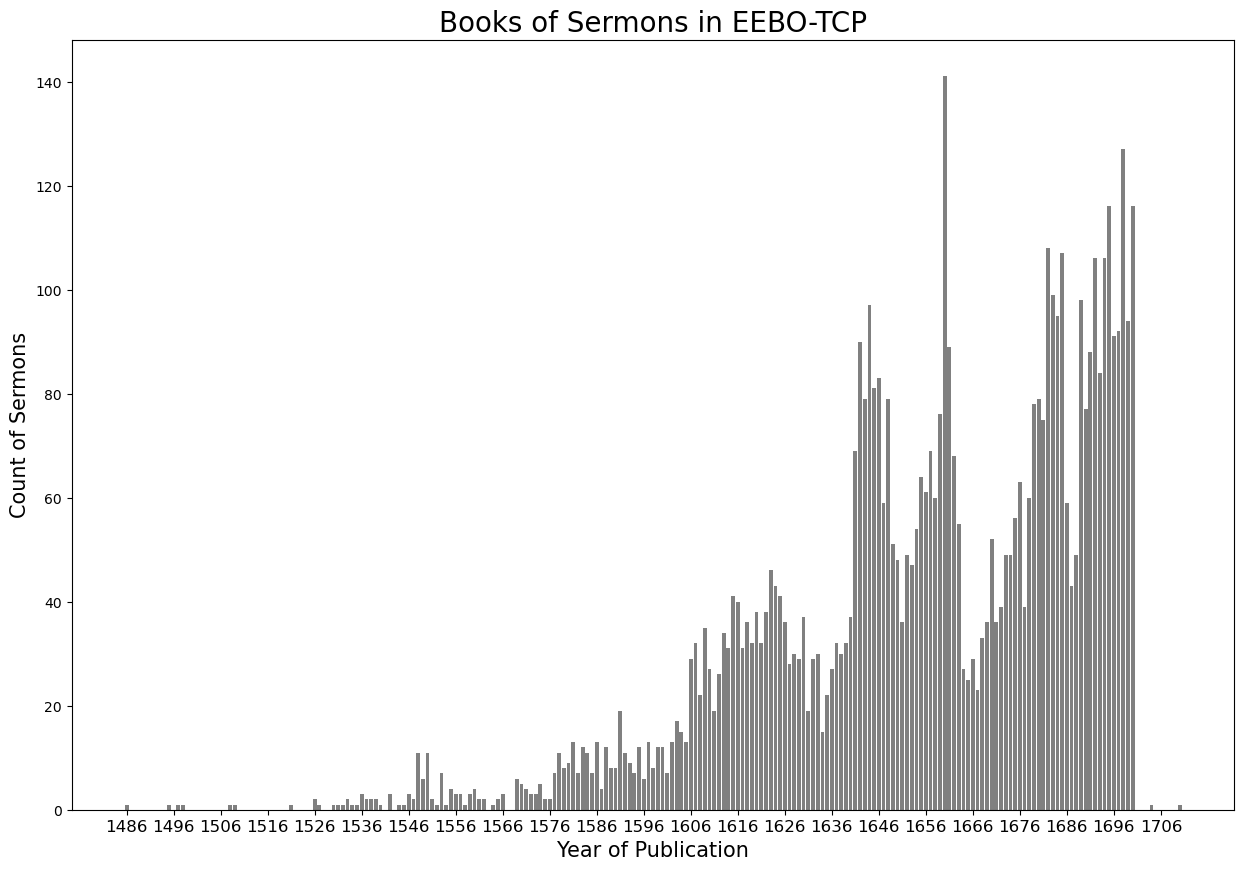

In [16]:
x,y = [],[]
date_counts = Counter(dates)
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Books of Sermons in EEBO-TCP','Year of Publication','Count of Sermons','grey')

In [17]:
print(Counter(dates).most_common(n=10))

[('1660', 141), ('1698', 127), ('1700', 116), ('1695', 116), ('1682', 108), ('1685', 107), ('1692', 106), ('1694', 106), ('1683', 99), ('1689', 98)]


In [18]:
posthumous = defaultdict(list)
within = defaultdict(list)
post_aut = []
within_aut = []
all_aut = []
aut_dup = {}
for k, v in duplicates.items(): 
    for item in v: 
        aut_dup[item] = k 

for idx, tcpID in enumerate(sermons): 
    date = dates[idx]
    aut = authors[idx].split("; ")
    if "?" in date: 
        date = date.split("-")[0]
    for author in aut:
        author = author.strip(" ").strip(".")
        if re.search(r'\w+[\)]{0,},',author):
            additional = re.findall(r'\d+(\.[\w+\-\,\s+\.]+)',author)
            if len(additional) > 0: 
                author = re.sub(additional[0], "",author)
        
        if author in aut_dup: 
            author = aut_dup[author]
        all_aut.append(author)

        if "England and Wales" in author or "House" in author: 
            within[date].append(tcpID)
            break
        elif author == "Anonymous": 
            break
        elif re.search(r"d. \d+",author): 
            yod = re.findall(r"d. (\d+)",author)[0]
            if date <= yod:
                within[date].append(tcpID)
                within_aut.append(tcpID)
        elif re.search(r'\d+[?]{0,1}-\d+[?]{0,1}',author): 
            years = re.findall('\d+',author)
            if date <= years[-1]: 
                within[date].append(tcpID)
                within_aut.append(author)
            else: 
                posthumous[date].append(tcpID)
                post_aut.append(author)

In [19]:
aut_tcpIDs = {}
from lib.dictionaries.author_duplicates import duplicates
dup_to_aut = {}
for k,v in duplicates.items(): 
    for aut in v: dup_to_aut[aut] = k

for idx, tcpID in enumerate(sermons): 
    date = dates[idx]
    aut = authors[idx].split("; ")
    if "?" in date: continue
    for author in aut:
        author = author.strip(" ").strip(".")
        if re.search(r'\w+[\)]{0,},',author):
            additional = re.findall(r'\d+(\.[\w+\-\,\s+\.]+)',author)
            if len(additional) > 0: 
                author = re.sub(additional[0], "",author)
        if author in dup_to_aut: 
            author = dup_to_aut[author]
        if author not in aut_tcpIDs: 
            aut_tcpIDs[author] = []
        aut_tcpIDs[author].append(tcpID)

In [20]:
new = []
for aut, tcpIDs in aut_tcpIDs.items(): 
    # if re.search(r'engraver|publisher|ed.',aut): continue 
    for tcpID in tcpIDs: 
        if {'author':aut,'tcpID':tcpID} not in new: 
            new.append({'author':aut,'tcpID':tcpID})

In [21]:
import csv
with open("/Users/amycweng/DH/SERMONS_APP/db/data/authors.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=['author','tcpID'])
    writer.writerows(new)

In [22]:
tcpIDs_aut = {}
for aut, tcpIDs in aut_tcpIDs.items(): 
    for t in tcpIDs: 
        if t not in tcpIDs_aut: tcpIDs_aut[t] = []
        tcpIDs_aut[t].append(aut)

In [23]:
len(tcpIDs_aut)

5755

In [24]:
single_aut, multiple_aut = {},{}
for tcpID, aut in tcpIDs_aut.items(): 
    if len(aut) == 1: 
        aut = aut[0]
        if aut not in single_aut: 
            single_aut[aut] = []
        single_aut[aut].append(tcpID)
    else: 
        aut = "; ".join(aut)
        if aut not in multiple_aut: 
            multiple_aut[aut] = []
        multiple_aut[aut].append(tcpID)

In [26]:
len(single_aut), len(multiple_aut)

(2305, 594)

In [27]:
sum([len(v) for v in single_aut.values()]),sum([len(v) for v in multiple_aut.values()])

(5087, 668)

In [28]:
singles = [k for k,v in single_aut.items() if len(v) == 1]
len(singles)

1442

In [ ]:
prefix = [k[:2] for k in singles]
from collections import Counter 
Counter(prefix)

In [30]:
print(Counter(all_aut).most_common(n=10))

[('Anonymous', 73), ('Tillotson, John, 1630-1694', 49), ('Burnet, Gilbert, 1643-1715', 38), ('Baxter, Richard, 1615-1691', 36), ('Stillingfleet, Edward, 1635-1699', 33), ('Reynolds, Edward, 1599-1676', 32), ('Calamy, Edmund, 1600-1666', 28), ('Hardy, Nathaniel, 1618-1670', 28), ('Donne, John, 1572-1631', 27), ('Smith, Henry, 1550?-1591', 27)]


In [31]:
print(Counter(post_aut).most_common(n=25))

[('Preston, John, 1587-1628', 26), ('Burroughs, Jeremiah, 1599-1646', 18), ('Smith, Henry, 1550?-1591', 15), ('Love, Christopher, 1618-1651', 12), ('Fenner, William, 1600-1640', 12), ('Calvin, Jean, 1509-1564', 12), ('Tillotson, John, 1630-1694', 12), ('Perkins, William, 1558-1602', 11), ('Manton, Thomas, 1620-1677', 10), ('Donne, John, 1572-1631', 9), ('Hopkins, Ezekiel, 1634-1690', 7), ('Luther, Martin, 1483-1546', 7), ('Gray, Andrew, 1633-1656', 7), ('Boyle, Robert, 1627-1691', 7), ('Stoughton, John, 1593-1639', 7), ('Andrewes, Lancelot, 1555-1626', 7), ('Sanderson, Robert, 1587-1663', 6), ('Dyke, Jeremiah, 1584-1639', 6), ('Rollock, Robert, 1555?-1599', 6), ('Playfere, Thomas, 1561?-1609', 6), ('Taylor, Thomas, 1576-1632', 5), ('Durham, James, 1622-1658', 5), ('Shepard, Thomas, 1605-1649', 5), ('Jewel, John, 1522-1571', 5), ('Barrow, Isaac, 1630-1677', 5)]


In [32]:
print(Counter(within_aut).most_common(n=25))

[('Burnet, Gilbert, 1643-1715', 38), ('Tillotson, John, 1630-1694', 37), ('Hardy, Nathaniel, 1618-1670', 27), ('Patrick, Simon, 1626-1707', 27), ('Williams, John, 1636?-1709', 24), ('Goodwin, Thomas, 1600-1680', 24), ('Marshall, Stephen, 1594?-1655', 24), ('Sherlock, William, 1641?-1707', 22), ('Sharp, John, 1645-1714', 22), ('Collinges, John, 1623-1690', 20), ('Mather, Cotton, 1663-1728', 20), ('Fuller, Thomas, 1608-1661', 20), ('Mather, Increase, 1639-1723', 19), ('Gataker, Thomas, 1574-1654', 19), ('Bates, William, 1625-1699', 18), ('Donne, John, 1572-1631', 18), ('Andrewes, Lancelot, 1555-1626', 18), ('Adams, Thomas, fl. 1612-1653', 18), ('Howe, John, 1630-1705', 17), ('Hall, Joseph, 1574-1656', 16), ('Shower, John, 1657-1715', 16), ('Bridge, William, 1600?-1670', 16), ('Willard, Samuel, 1640-1707', 15), ('Harris, Robert, 1581-1658', 15), ('Case, Thomas, 1598-1682', 15)]


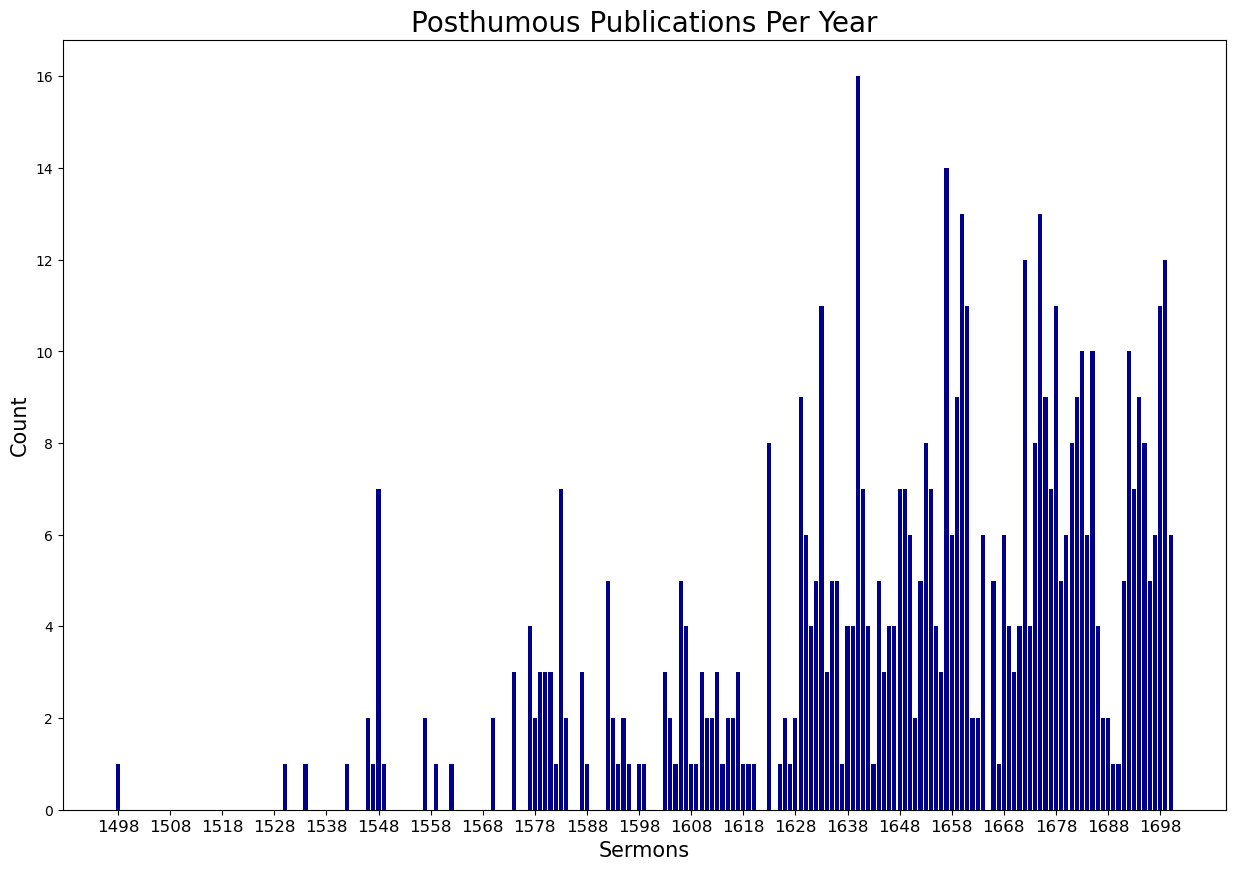

In [33]:
x,y = [],[]
date_counts = {date: len(tcpIDs) for date, tcpIDs in Counter(posthumous).items()}
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    if int(date) > 1700: continue
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Posthumous Publications Per Year','Sermons','Count','darkblue')

In [34]:
print(sorted(date_counts.items(),reverse=True, key=lambda x:x[1]))

[('1640', 16), ('1657', 14), ('1660', 13), ('1675', 13), ('1672', 12), ('1699', 12), ('1633', 11), ('1678', 11), ('1661', 11), ('1698', 11), ('1685', 10), ('1692', 10), ('1683', 10), ('1676', 9), ('1659', 9), ('1629', 9), ('1694', 9), ('1682', 9), ('1653', 8), ('1681', 8), ('1623', 8), ('1674', 8), ('1695', 8), ('1649', 7), ('1641', 7), ('1693', 7), ('1548', 7), ('1583', 7), ('1677', 7), ('1654', 7), ('1648', 7), ('1680', 6), ('1650', 6), ('1684', 6), ('1668', 6), ('1658', 6), ('1700', 6), ('1697', 6), ('1664', 6), ('1630', 6), ('1691', 5), ('1652', 5), ('1644', 5), ('1632', 5), ('1666', 5), ('1592', 5), ('1635', 5), ('1696', 5), ('1679', 5), ('1636', 5), ('1606', 5), ('1646', 4), ('1577', 4), ('1671', 4), ('1647', 4), ('1669', 4), ('1638', 4), ('1655', 4), ('1686', 4), ('1673', 4), ('1631', 4), ('1607', 4), ('1642', 4), ('1639', 4), ('1617', 3), ('1587', 3), ('1634', 3), ('1670', 3), ('1610', 3), ('1645', 3), ('1656', 3), ('1579', 3), ('1581', 3), ('1580', 3), ('1574', 3), ('1613', 3)

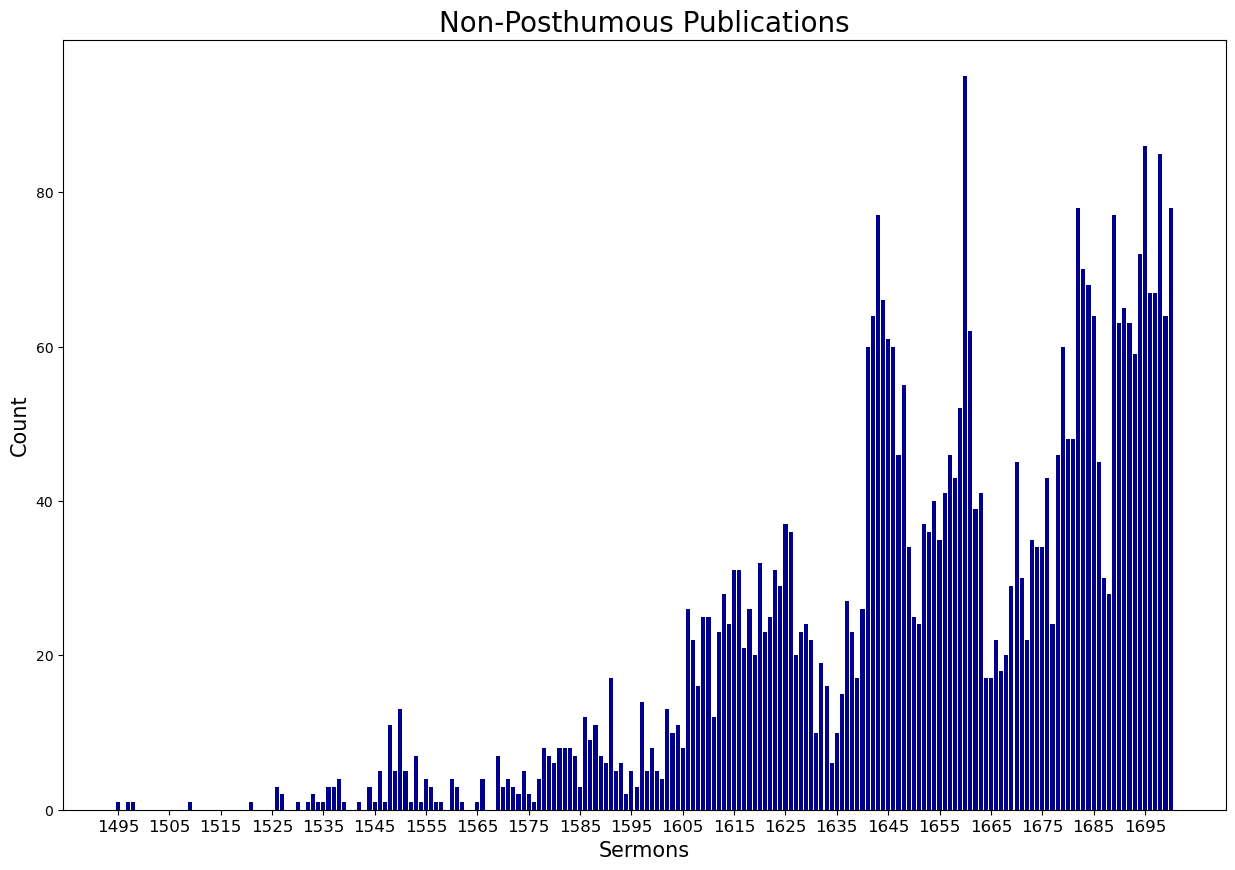

In [35]:
x,y = [],[]
date_counts = {date: len(tcpIDs) for date, tcpIDs in Counter(within).items()}
for date in sorted(date_counts): 
    if "?" in date: continue
    if "-" in date: 
        date = date.split("-")[0]
    if int(date) > 1700: continue
    x.append(int(date))
    y.append(date_counts[date])
visualize(x,y,'Non-Posthumous Publications','Sermons','Count','darkblue')

In [36]:
print(sorted(date_counts.items(),reverse=True, key=lambda x:x[1]))

[('1660', 95), ('1695', 86), ('1698', 85), ('1682', 78), ('1700', 78), ('1643', 77), ('1689', 77), ('1694', 72), ('1683', 70), ('1684', 68), ('1697', 67), ('1696', 67), ('1644', 66), ('1691', 65), ('1642', 64), ('1685', 64), ('1699', 64), ('1690', 63), ('1692', 63), ('1661', 62), ('1645', 61), ('1679', 60), ('1641', 60), ('1646', 60), ('1693', 59), ('1648', 55), ('1659', 52), ('1681', 48), ('1680', 48), ('1657', 46), ('1647', 46), ('1678', 46), ('1686', 45), ('1670', 45), ('1676', 43), ('1658', 43), ('1656', 41), ('1663', 41), ('1654', 40), ('1662', 39), ('1652', 37), ('1625', 37), ('1653', 36), ('1626', 36), ('1655', 35), ('1673', 35), ('1649', 34), ('1675', 34), ('1674', 34), ('1620', 32), ('1623', 31), ('1615', 31), ('1616', 31), ('1671', 30), ('1687', 30), ('1669', 29), ('1624', 29), ('1613', 28), ('1688', 28), ('1637', 27), ('1640', 26), ('1606', 26), ('1618', 26), ('1609', 25), ('1650', 25), ('1622', 25), ('1610', 25), ('1651', 24), ('1629', 24), ('1614', 24), ('1677', 24), ('163

In [37]:
sorted_dates = sorted(date_counts)
print(sorted_dates[0],sorted_dates[-1])
date_to_tcpID = {}
for idx, date in enumerate(dates):
    if date not in date_to_tcpID: 
        date_to_tcpID[date] = []
    date_to_tcpID[date].append(sermons[idx])

    

1495 1700


In [38]:
x,y = [],[]
author_pubs = defaultdict(list)
for idx, author in enumerate(authors): 
    aut = author.split("; ")
    for a in aut: 
        a = a.strip(r"  ").strip(".")
        if re.search(r'\w+[\)]{0,},',a):
            additional = re.findall(r'\d+(\.[\w+\-\,\. ]+)',a)
            if len(additional) > 0: 
                a = re.sub(additional[0], "",a)
        author_pubs[a].append(dates[idx])

In [39]:
from lib.dictionaries.author_duplicates import duplicates
known_dups = {}
for k, v in duplicates.items(): 
    known_dups[k] = 0
    for item in v:  
        known_dups[item] = 0

In [40]:
prefixes = {}
for a in author_pubs: 
    if a in known_dups: continue
    prefix = a.split(" ")[:2]
    prefix = " ".join(prefix)
    if prefix not in prefixes: 
        prefixes[prefix] = []
    if a not in prefixes[prefix]: 
        prefixes[prefix].append(a)

for prefix, p_list in prefixes.items(): 
    if len(p_list) > 1: 
        print(f"'{prefix}': {p_list},")

'Lover of': ['Lover of ale', 'Lover of peace and truth'],
'Sharp, John,': ['Sharp, John, of Froome, Somersetshire', 'Sharp, John, 1645-1714'],
'Williams, John,': ['Williams, John, minister', 'Williams, John, 1636?-1709', 'Williams, John, Master of Arts', 'Williams, John, 1582-1650', 'Williams, John, 1664-1729'],
'White, Thomas,': ['White, Thomas, 1628-1698', 'White, Thomas, ca. 1550-1624', 'White, Thomas, 1593-1676'],
'Hancock, John,': ['Hancock, John, fl. 1669-1705', 'Hancock, John, fl. 1638-1675'],
'Ross, Alexander,': ['Ross, Alexander, 1647?-1720', 'Ross, Alexander, 1591-1654'],
'Abbot, Robert,': ['Abbot, Robert, 1588?-1662?', 'Abbot, Robert, 1560-1618'],
'J. B.': ['J. B. (John Bulteel), d. 1669', 'J. B. (John Bird), b. 1584 or 5', 'J. B. (John Butler)', 'J. B. (James Bradshaw), 1636?-1702'],
'Du Moulin,': ['Du Moulin, Pierre, 1568-1658', 'Du Moulin, Peter, 1601-1684'],
'Gardiner, Samuel,': ['Gardiner, Samuel, b. 1563 or 4', 'Gardiner, Samuel, 1619 or 20-1686'],
'Hart, John,': ['Har

In [41]:
author_counts = {aut: len(pubs) for aut, pubs in author_pubs.items()}
for aut,freq in sorted(author_counts.items(), key = lambda x: x[1],reverse=True)[:10]: 
    print(freq, "\t", aut, "\t", Counter(author_pubs[aut]))

73 	 Anonymous 	 Counter({'1663': 4, '1643': 3, '1687': 3, '1678': 3, '1644': 3, '1685': 3, '1660': 2, '1672': 2, '1645': 2, '1641': 2, '1688': 2, '1674': 2, '1585': 2, '1689': 2, '1698': 2, '1670': 2, '1683': 2, '1684': 2, '1650': 2, '1700': 2, '1611': 1, '1704': 1, '1699': 1, '1548': 1, '1673': 1, '1662': 1, '1542': 1, '1559': 1, '1671': 1, '1680': 1, '1607': 1, '1635': 1, '1667': 1, '1694': 1, '1676': 1, '1600-1699?': 1, '1675': 1, '1664': 1, '1682': 1, '1648': 1, '1692': 1, '1691': 1, '1653': 1, '1677': 1, '1640': 1, '1603': 1})
49 	 Tillotson, John, 1630-1694 	 Counter({'1694': 5, '1700': 4, '1687': 3, '1695': 3, '1679': 3, '1675': 3, '1693': 3, '1689': 3, '1690': 3, '1678': 2, '1698': 2, '1692': 2, '1682': 2, '1676': 1, '1691': 1, '1664': 1, '1696': 1, '1680': 1, '1697': 1, '1685': 1, '1681': 1, '1699': 1, '1686': 1, '1683': 1})
38 	 Burnet, Gilbert, 1643-1715 	 Counter({'1689': 8, '1690': 5, '1681': 3, '1697': 3, '1691': 3, '1694': 3, '1675': 3, '1684': 2, '1698': 2, '1700': 1, 

In [42]:
prefixes = ['B','A0','A1','A2','A3','A4','A5','A6','A7','A8','A9']

In [43]:
def get_era(start,end):
    era = {k:[] for k in prefixes}
    for idx, date in enumerate(dates): 
        tcpID = sermons[idx]
        if "-" in date: 
            date = int(date.split("-")[0])
        date = int(date)
        if 'B' in tcpID: 
            prefix = 'B'
        else: 
            prefix = tcpID[:2]
        if start <= date <= end:
            era[prefix].append(tcpID)
    return era 

In [44]:
preE = get_era(1400,1557)
E = get_era(1558,1602)
J = get_era(1603,1624)
C = get_era(1625,1641)
CW = get_era(1642,1649)
IR = get_era(1650,1659)
CII = get_era(1660,1684)
JII = get_era(1685,1688)
WM = get_era(1689,1702)

corpora = {"pre-Elizabethan":preE,"Elizabethan":E, "Jacobean":J, "Carolinian":C,"CivilWar":CW,"Interregnum":IR,
        "CharlesII":CII, "JamesII":JII, "WilliamAndMary":WM}

for era, corpus in corpora.items(): 
    print(era, sum([len(_) for _ in corpus.values()]))


pre-Elizabethan 86
Elizabethan 308
Jacobean 678
Carolinian 543
CivilWar 619
Interregnum 565
CharlesII 1503
JamesII 258
WilliamAndMary 1195


In [45]:
import json
with open('../assets/corpora.json','w+') as file: 
    json.dump(corpora,file)